In [1]:
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from IPython.core.ultratb import AutoFormattedTB
from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image as pImage
import torchvision
from torchvision import transforms, utils, datasets
from tqdm import tqdm
import traceback

assert torch.cuda.is_available()
__ITB__ = AutoFormattedTB(mode='Verbose', color_scheme='LightBg', tb_offset=1)
np.set_printoptions(precision=2)
torch.set_printoptions(precision=2)
MODEL_PATH = 'cancer_model.params'

# Cancer Detection via Image Segmentation

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?media=cs501r_f2016:screen_shot_2017-10-10_at_10.11.55_am.png)

## Model Definition

In [2]:
class UNetModel(nn.Module):
  
    def __init__(self):
        """
        A fully-connected linear layer that takes m inputs and returns n outputs.
        """
        super().__init__()
        # Starting size: (n, 3, 512, 512)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        ) 
        # outputs: (n, 64, 512, 512)
        self.conv2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # (n, 128, 128, 128)
        self.conv3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # (n, 256, 64, 64)
        self.conv4 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # (n, 512, 32, 32)
        self.conv5 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # (n, 1024, 32, 32)
        # Upconvolutions halve the number of feature channels,
        # then concatenate with the downsampling layer.
        self.upconv6 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU()
        )
        # (n, 512, 64, 64)
        # concatenate with contracting path features
        # (n, 1024, 64, 64)
        self.conv6 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # (n, 512, 64, 64)
        self.upconv7 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU()
        )
        # (n, 256, 128, 128)
        # concatenate with contracting path features
        # (n, 512, 128, 128)
        self.conv7 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # (n, 256, 128, 128)
        self.upconv8 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU()
        )
        # (n, 128, 256, 256)
        # concatenate with contracting path features
        # (n, 256, 256, 256)
        self.conv8 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # (n, 128, 256, 256)
        self.upconv9 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU()
        )
        # (n, 64, 512, 512)
        # concatenate with contracting path features
        # (n, 128, 512, 512)
        self.conv9 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 2, kernel_size=1)
        )
        # (n, 2, 512, 512)
        
        self.linear = nn.Conv2d(3, 2, kernel_size=1)
            
    def forward(self, x):
#         x = torch.Tensor(np.random.random(x.shape)).cuda()
#         return self.linear(x)
        # (n,3,512,512)
        x1 = self.conv1(x) # (n,64,512,512)
        x2 = self.conv2(x1) # (n,128,256,256)
        x3 = self.conv3(x2) # (n,256,128,128)
        x4 = self.conv4(x3) # (n,512,64,64)
        x5 = self.conv5(x4) # x5 is the output of the "bottom" layer (n,1024,32,32)
        x6 = self.conv6(torch.cat((x4, self.upconv6(x5)), dim=1)) # (n,512,64,64)
        x7 = self.conv7(torch.cat((x3, self.upconv7(x6)), dim=1)) # (n,256,128,128)
        x8 = self.conv8(torch.cat((x2, self.upconv8(x7)), dim=1)) # (n,128,256,256)
        x9 = self.conv9(torch.cat((x1, self.upconv9(x8)), dim=1)) # (n,2,512,512)
        return x9 #(n,2,512,512)
        

    def param_count(self):
        return np.sum([np.prod(param.shape) for param in list(self.parameters())])
  

class CancerDataset(Dataset):
    def __init__(self, dataset_folder, dataset_type):
        self.dataset_type = dataset_type
        if dataset_type == 'train':
            self.dataset_folder = torchvision.datasets.ImageFolder(dataset_folder + 'inputs_train/', transform = transforms.ToTensor())
            self.label_folder = torchvision.datasets.ImageFolder(dataset_folder + 'outputs_train/', transform = transforms.ToTensor())
        elif dataset_type == 'test':
            self.dataset_folder = torchvision.datasets.ImageFolder(dataset_folder + 'inputs_test/', transform = transforms.ToTensor())
            self.label_folder = torchvision.datasets.ImageFolder(dataset_folder + 'outputs_test/', transform = transforms.ToTensor())
        elif dataset_type == 'overfit':
            self.dataset_folder = torchvision.datasets.ImageFolder(dataset_folder + 'inputs_overfit/', transform = transforms.ToTensor())
            self.label_folder = torchvision.datasets.ImageFolder(dataset_folder + 'outputs_overfit/', transform = transforms.ToTensor())
        else:
            assert False, "Incorrect dataset_type."
            
    def __getitem__(self,index):
        """
        Returns:
            x (3, 512, 512) - float in [0,1).
            y (512, 512) - byte in {0,1}.
        """
        img = self.dataset_folder[index]
        label = self.label_folder[index]
        return img[0],label[0][0] # ImageLoader converts grayscale to RGB, so slice only the first color dimension

    def __len__(self):
        if self.dataset_type == 'overfit':
            return 1
        elif self.dataset_type == 'train':
            return len(self.dataset_folder)
        return len(self.dataset_folder)

## Helper Methods

In [3]:
def display_sample(filename):
    display(Image(filename=filename))
    
def display_x_tensor(t, title=None):
    npimg = t.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    if title:
        plt.title(title)
    plt.show()
    
def display_y_tensor(t, title=None):
    npimg = t.cpu().detach().numpy()
    npimg = np.expand_dims(npimg, axis=0)
    npimg = np.repeat(npimg, 3, axis=0)
    npimg = np.transpose(npimg, (1,2,0)).astype(int)
    plt.imshow(255*npimg, interpolation='nearest')
    if title:
        plt.title(title)
    plt.show()
    
    
def resize(folder):
    img_names = os.listdir(folder)
    for img_name in img_names:
        path = folder + img_name
        img = Image.open(path)
        img = img.resize((512,512), PIL.Image.NEAREST)
        img.save(path)

def resize_all_images():
    folders = ['cancer_data/inputs_test/0/',
               'cancer_data/inputs_train/0/',
               'cancer_data/outputs_test/0/',
               'cancer_data/outputs_train/0/']
    for folder in folders:
        resize(folder)

def print_memory():
    print(torch.cuda.memory_allocated(0)/1e9, "GB")

In [4]:
def get_gradient_norm(model):
    sum_g_squared = 0
    for param in model.parameters():
        sum_g_squared += torch.sum(param.view(-1)**2).item()
    grad_norm = np.sqrt(sum_g_squared)
    return grad_norm

def plot_activations(model, x):
    weights_per_layer = []
    for child in model.children():
        print(x.shape)
        print(child)
        x = child(x)
        weights_per_layer.append(x.view(-1).detach().cpu().numpy())
    plt.hist(weights_per_layer[0])
    plt.title("First-Layer Activations")
    plt.show()
    
def plot_weights(model):
    weights_per_layer = []
    for child in model.children():
        weight = child[0].weight
        weights_per_layer.append(weight.view(-1).detach().cpu().numpy())
        break
    print(weights_per_layer[0].shape)
    plt.hist(weights_per_layer[0])
    plt.title("First-Layer Weights")

In [5]:
print_memory()

0.0 GB


Unhandled exceptions cause a memory leak. Wrap expensive model creation in try-except. 
Call `gc.collect()` for eager garbage collection. 
`torch.cuda.memory_allocated(0)/1e9` gives the memory GBs used.

epoch:0, loss:0.463, accuracy:0.836, mem:3.52:  10%|█         | 671/6710 [04:10<37:59,  2.65it/s] 

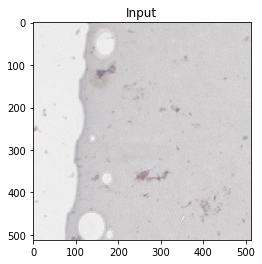

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


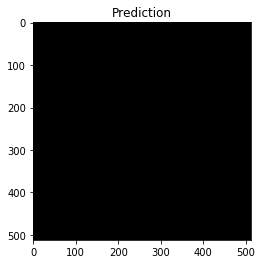

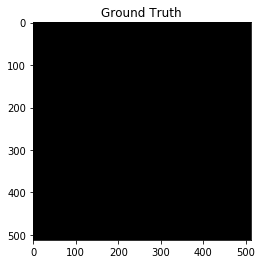

epoch:1, loss:0.127, accuracy:0.964, mem:3.52:  20%|██        | 1342/6710 [08:24<33:56,  2.64it/s]

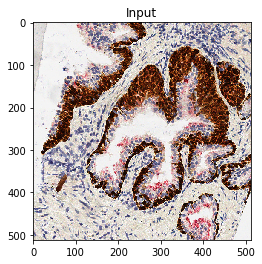

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


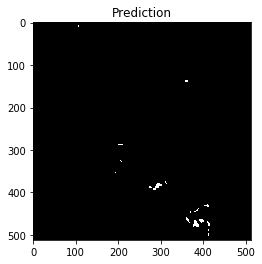

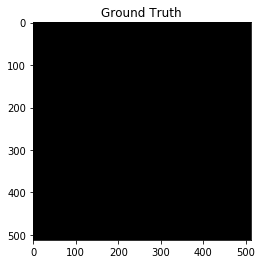

epoch:2, loss:0.487, accuracy:0.812, mem:3.52:  30%|███       | 2013/6710 [12:38<29:36,  2.64it/s]

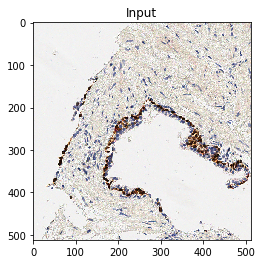

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


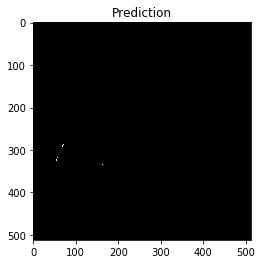

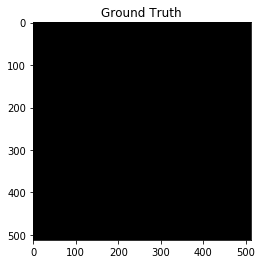

epoch:3, loss:0.460, accuracy:0.841, mem:3.52:  40%|████      | 2684/6710 [16:53<25:24,  2.64it/s]

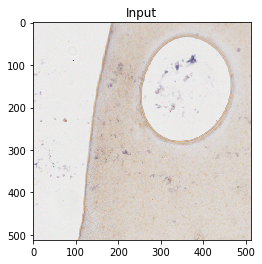

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


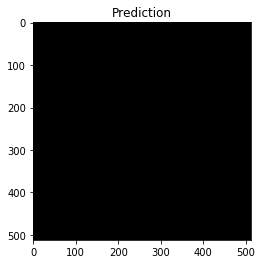

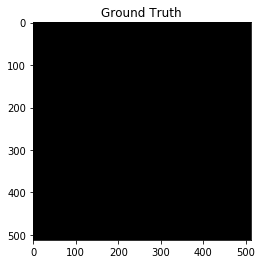

epoch:4, loss:0.711, accuracy:0.786, mem:3.52:  50%|█████     | 3355/6710 [21:07<21:13,  2.63it/s]

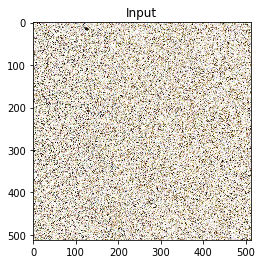

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


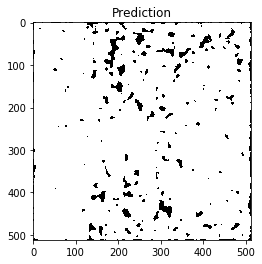

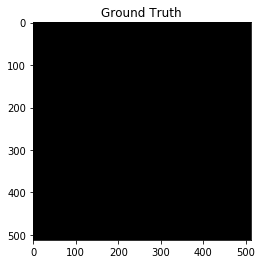

epoch:5, loss:0.472, accuracy:0.804, mem:3.52:  60%|██████    | 4026/6710 [25:22<16:57,  2.64it/s]

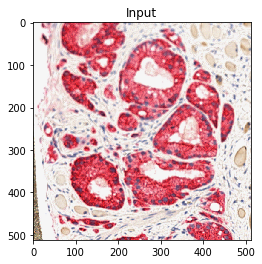

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


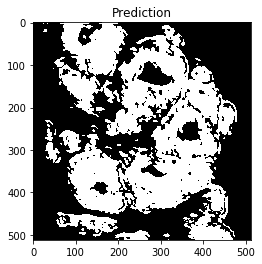

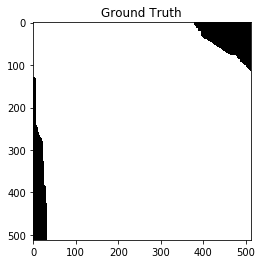

epoch:6, loss:0.274, accuracy:0.897, mem:3.52:  70%|███████   | 4697/6710 [29:36<12:41,  2.64it/s]

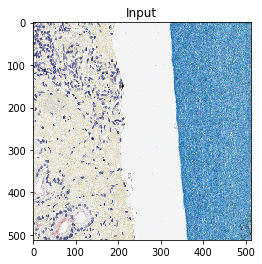

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


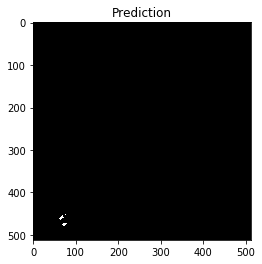

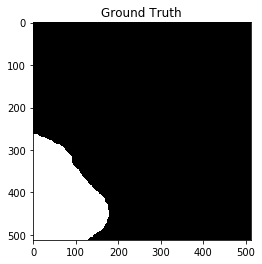

epoch:7, loss:0.375, accuracy:0.871, mem:3.52:  80%|████████  | 5368/6710 [33:50<08:28,  2.64it/s]

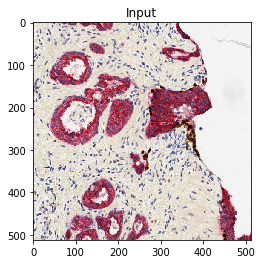

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


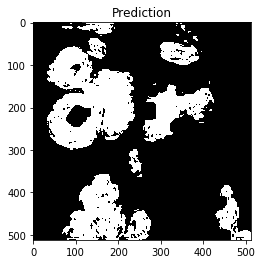

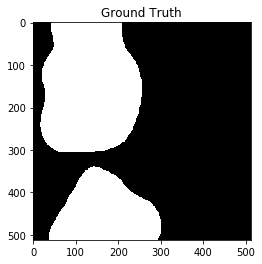

epoch:8, loss:0.024, accuracy:1.000, mem:3.52:  90%|█████████ | 6039/6710 [38:05<04:14,  2.63it/s]

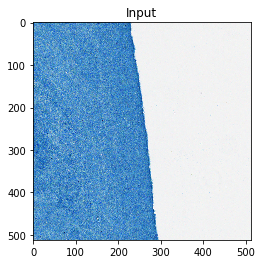

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


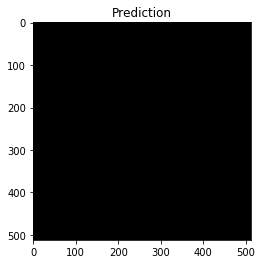

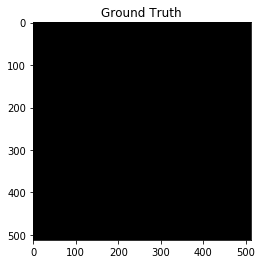

epoch:9, loss:0.408, accuracy:0.773, mem:3.52: 100%|██████████| 6710/6710 [42:20<00:00,  2.64it/s]

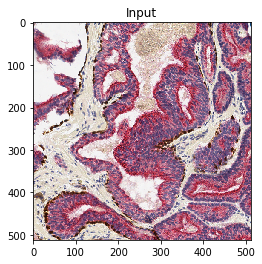

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


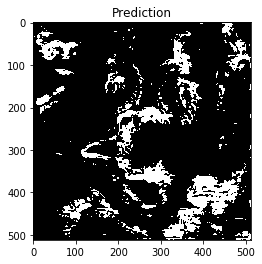

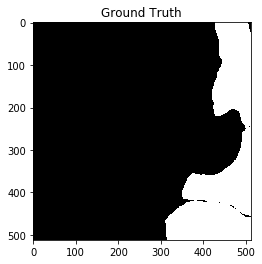

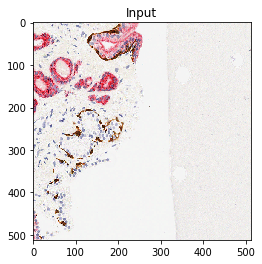

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


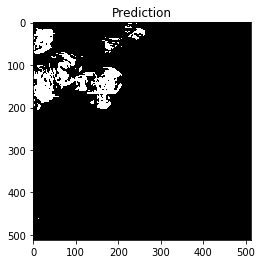

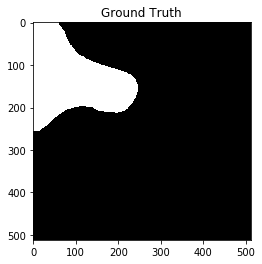

In [6]:
def scope(num_epochs, lr):
    try:
        train_dataset = CancerDataset(dataset_folder='cancer_data/', dataset_type='train')
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=2,
            pin_memory=True,
            shuffle=True
        )
        test_dataset = CancerDataset(dataset_folder='cancer_data/', dataset_type='test')
        test_x, test_y = test_dataset[172]
        test_x, test_y = test_x.cuda(), test_y.cuda()

        gc.collect()
        model = UNetModel().cuda()
        model.load_state_dict(torch.load(MODEL_PATH))
        objective = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        loop = tqdm(total=num_epochs*len(train_loader), position=0)

        gc.collect()
        torch.cuda.empty_cache()
        
#         print_memory()
        losses_per_epoch = []
        accuracy_per_epoch = []
        gradient_norms = []
        for epoch in range(num_epochs):
            training_losses = []
            training_accuracies = []
            for i, data in enumerate(train_loader):
                x, y_truth = data
                x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
                
                optimizer.zero_grad()
                y_hat = model(x)
                loss = objective(y_hat, y_truth.long())
                training_losses.append(loss.item())
                
                accuracy = (y_hat.argmax(dim=1) == y_truth.long()).float().mean()
                training_accuracies.append(accuracy.item())
                mem = torch.cuda.memory_allocated(0) / 1e9

                loop.set_description("epoch:{}, loss:{:.3f}, accuracy:{:.3f}, mem:{:.2f}".format(
                    epoch, loss.item(), accuracy, mem))
                loop.update(1)

                loss.backward()
                optimizer.step()

            gradient_norms.append(get_gradient_norm(model))
            losses_per_epoch.append(np.mean(training_losses))
            accuracy_per_epoch.append(np.mean(training_accuracies))
            torch.save(model.state_dict(), MODEL_PATH)
            
            display_x_tensor(x[0], title="Input")
            display_y_tensor(y_hat[0][1], title="Prediction")
            display_y_tensor(y_truth[0], title="Ground Truth")

        loop.close()  
        
        return losses_per_epoch, accuracy_per_epoch, gradient_norms
    except:
        print(traceback.format_exc())
#         __ITB__()
    finally:
        gc.collect()
        torch.save(model.state_dict(), MODEL_PATH)
        test_y_hat = model(test_x.unsqueeze(0))
        display_x_tensor(test_x, title="Input")
        display_y_tensor(test_y_hat[0][1], title="Prediction")
        display_y_tensor(test_y, title="Ground Truth")
     
num_epochs = 10
lr = 0.001
losses, accuracies, gradient_norms = scope(num_epochs, lr)

In [13]:
gc.collect()

12899

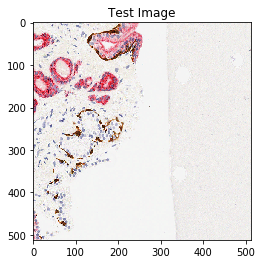

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


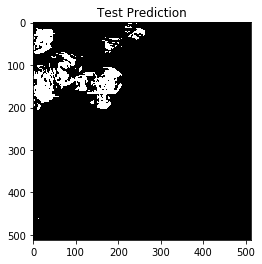

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


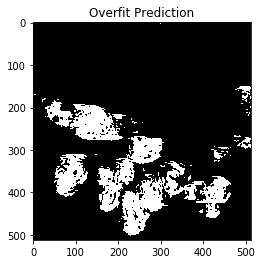

In [7]:
def display_test_image():
    gc.collect()
    model = UNetModel().cuda()
    model.load_state_dict(torch.load(MODEL_PATH))

    overfit_dataset = CancerDataset(dataset_folder='cancer_data/', dataset_type='overfit')
    overfit_x, overfit_y = overfit_dataset[0]
    overfit_x, overfit_y = overfit_x.cuda(), overfit_y.cuda()

    test_dataset = CancerDataset(dataset_folder='cancer_data/', dataset_type='test')
    test_x, test_y = test_dataset[172]
    test_x, test_y = test_x.cuda(), test_y.cuda()


    test_y_hat = model(test_x.unsqueeze(0))
    display_x_tensor(test_x, title="Test Image")
    display_y_tensor(test_y_hat[0][1], title="Test Prediction")

    overfit_y_hat = model(overfit_x.unsqueeze(0))
    display_y_tensor(overfit_y_hat[0][1], title="Overfit Prediction")
    
display_test_image()

In [8]:
objective = nn.CrossEntropyLoss()

y_truth_np = -100*np.ones((1,512,512))
y_hat_np = 100*np.concatenate((
    np.ones((1,1,512,512)),
    np.zeros((1,1,512,512))
), axis=1)

# y_truth_np = np.array([
#     [0, 0],
#     [0, 0]
# ]).reshape(1, 2, 2)
# y_hat_np = np.array([
#         [[1,1],
#          [1,1]],
#         [[0,0],
#          [0,0]]
# ]).reshape(1, 2, 2, 2)
y_truth = torch.Tensor(y_truth_np).long()
y_hat = torch.tensor(y_hat_np).float()

print(y_hat.shape, y_truth.shape)

loss = objective(y_hat, y_truth)
print(loss)

torch.Size([1, 2, 512, 512]) torch.Size([1, 512, 512])
tensor(0.)


The initial classifications are either all 1's or all 0's. The softmax classifications are all close to each other for related pixels, which isn't surprising, but it's not learning at all. Classsification accuracy stays the same.

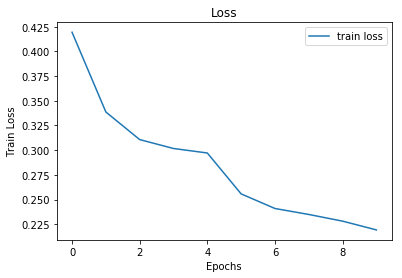

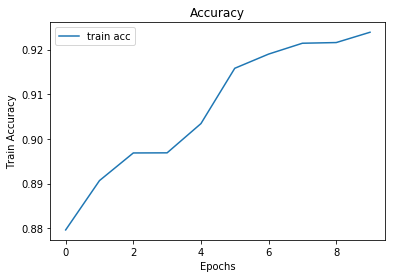

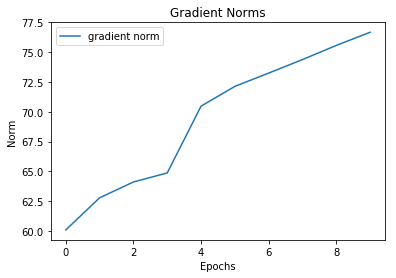

In [16]:
t = np.arange(num_epochs)
plt.plot(t, losses, label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(t, accuracies, label="train acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.legend()
plt.show()

plt.plot(t, gradient_norms, label="gradient norm")
plt.xlabel("Epochs")
plt.ylabel("Norm")
plt.legend()
plt.title("Gradient Norms")
plt.show()

Random Init Loss: 0.73  
Random Init Acc: 0.48